A written summary of this notebook can be found here:
<a href="https://docs.google.com/document/d/1ETmrPD0bNYyqMHw8DUY-Kd8kE8OtlkSNkLyPhkASjn8/edit#">
    Google Doc </a>


# Downloading the necessary packages and data

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [281]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
main2=pd.read_pickle('Data/data_from_imdb_extra.pkl')

In [6]:
main2.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave'],
      dtype='object')

In [9]:
month_df=pd.read_pickle('Data/df_of_months')
prodcomp_df=pd.read_pickle('Data/df_previous_nom_production_comp.pkl')

In [10]:
month_df.head(2)

,imdb_id,day,month,year,country,month_num
0,0388130,13,Jan,2001,(Japan),1
1,0273772,17,Jan,2001,(France),1


In [11]:
prodcomp_df.head(2)

,imdb_id,prev nom pcomp,prev nom pcomp encoded
0,0388130,Not Previously Nominated,0
1,0273772,Not Previously Nominated,0


In [12]:
main2['month']=month_df['month_num']
main2['prev_pc'] = prodcomp_df['prev nom pcomp encoded']

In [17]:
main2['runtimes']

0       [100]
1        [70]
2        [99]
3        [46]
4        [81]
        ...  
3896     [70]
3897     [78]
3898     [60]
3899     [90]
3900     [89]
Name: runtimes, Length: 3901, dtype: object

In [20]:
runtime_ints=[]
for i in range(len(main2)):
    runtime_ints.append(main2.iloc[i]['runtimes'][0])

In [21]:
main2['runtime_ints'] = runtime_ints

In [22]:
main2.to_pickle('Data/data_from_imdb_extra_2.pkl')

# Splitting the test and training data

In [23]:
main_df=pd.read_pickle('Data/data_from_imdb_extra_2.pkl')

In [24]:
#create a dataframe that drops given years
def drop_test(df,L):
    '''input a dataframe of movies (df) and a list of years as int (L)
    outputs a dataframe that does not include the movies in years in L'''
    indices =[]
    for i in range(len(df)):
        if df.iloc[i]['year'] in L:
            indices.append(i)
    new_df=df.drop(indices)
    return(new_df)

In [25]:
train_set=drop_test(main2, [2018,2019,2020,2021])

In [26]:
def timeseries_split(df, k):
    '''takes in a movie dataframe (df),  k (int)
    and outputs a tuple that behaves like kfold.split when kfold =kfold = TimeSeriesSplit(n_splits = k,
                           test_size = 1)
    that is, the output is a tuple of 2-tuples, where
    the first element of each tuple is the indices of the train set and
    the second element is the indices of the test set
    unlike TimeSeriesSplit it can only handle one dataframe at a time'''
    if len(df['year'].value_counts()) <k:
        raise ValueError("Not enough data for given k")
        
    df=df.copy()
    
    answer=[]
    i=0
    while i <k:
        last_year=df['year'].max()
        
        #get array of indices of last year in list
        index_set=np.array(df[df['year']==last_year].index)
        
        #delete rows from dataframe
        df=drop_test(df,[last_year])
        #print(len(df))
        
        #add to train_sets
        index_set2=np.array(df.index)
        
        new_set=(index_set2, index_set)
        answer=[new_set] + answer
        
        i=i+1
    
    return tuple(answer)

# Models based on more features

In [27]:
train_set.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave', 'month', 'prev_pc',
       'runtime_ints'],
      dtype='object')

In [131]:
viable_columns = [
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave', 'month', 'prev_pc',
       'runtime_ints']

### Random Forest

In [29]:
def est_forest(j):
    '''goes through j n-estimaters values on decision trees on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        k=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make random forest with maxdepth=10 and n_estimators=80
            tree=RandomForestClassifier(n_estimators=80, max_depth=10)
            tree.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=tree.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,k]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,k]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            k=k+1

    return(precs, recs)

In [30]:
metrics_forest=est_forest(1)

In [31]:
metrics_forest

(array([[1.        , 0.6       , 0.66666667, 0.8       , 0.33333333]]),
 array([[0.66666667, 0.6       , 0.66666667, 0.8       , 0.2       ]]))

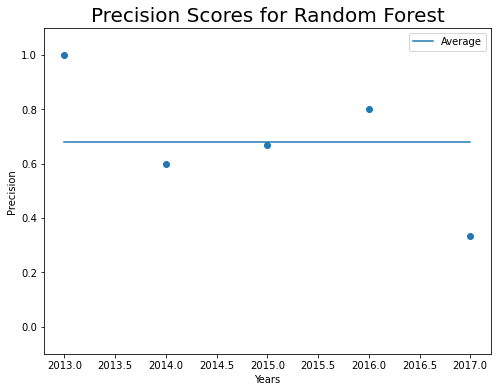

In [45]:
plt.figure(figsize=(8,6))

plt.scatter(range(2013,2018), metrics_forest[0])

plt.plot(range(2013,2018), 5*[np.mean(metrics_forest[0])], label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

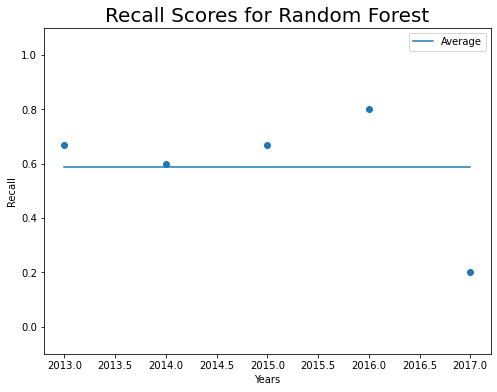

In [54]:
plt.figure(figsize=(8,6))

plt.scatter(range(2013,2018), metrics_forest[1])

plt.plot(range(2013,2018), 5*[np.mean(metrics_forest[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [42]:
print('Recall:')
print(np.mean(metrics_forest[1], axis=1))
print('Precision:')
print(np.mean(metrics_forest[0], axis=1))

Recall:
[0.58666667]
Precision:
[0.68]


#### <font color='MediumOrchid'>For Random Forests, these metrics are both lower than before we incorporated the new features. </font>

In [101]:
importances = forest.feature_importances_

In [102]:
importances

array([0.02661641, 0.02955042, 0.01131955, 0.01523862, 0.01756514,
       0.01496047, 0.00819095, 0.02739931, 0.00667012, 0.00286369,
       0.01963584, 0.06184498, 0.02469075, 0.01687009, 0.26609684,
       0.26460547, 0.07605391, 0.01742781, 0.09239963])

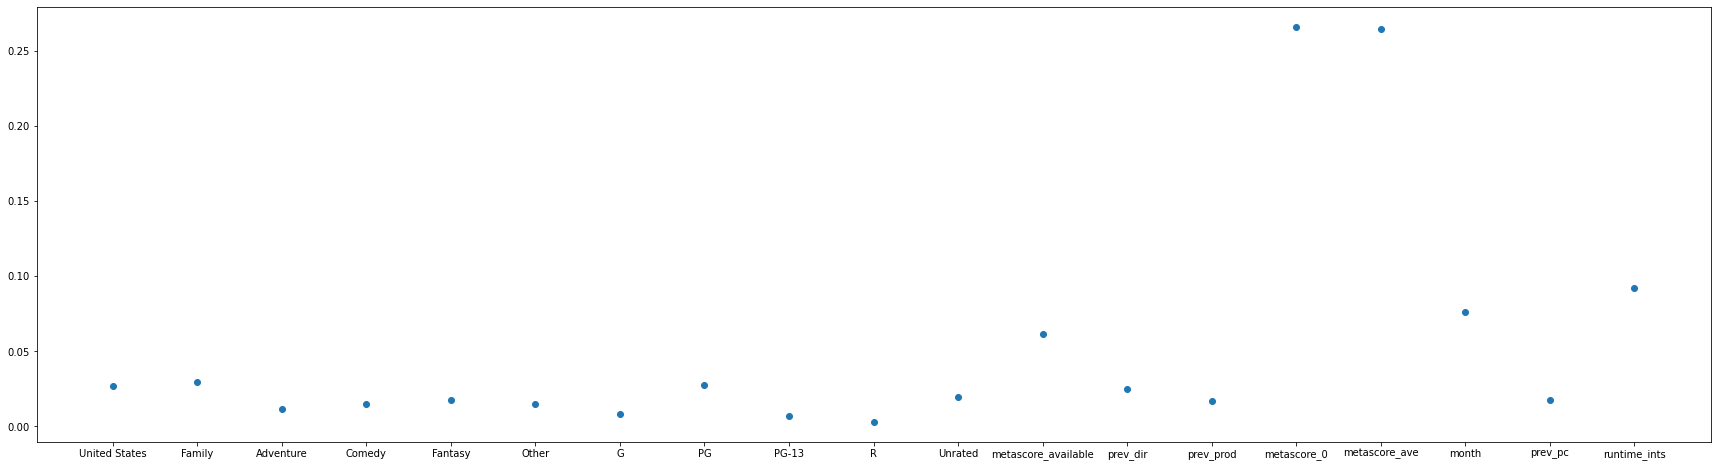

In [110]:
plt.figure(figsize=(30,8))

feature_names = [viable_columns]

#forest_importances = pd.Series(importances, index=feature_names)

plt.scatter(viable_columns, importances)

plt.show()

### k Nearest Neighbors Classifier

In [47]:
def est_knn(j):
    '''goes through k in range(1,j+1) on kNN models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1, p=1)
            kNN.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=kNN.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [48]:
metrics_knn=est_knn(1)

In [49]:
metrics_knn

(array([[0.33333333, 0.8       , 0.66666667, 0.44444444, 0.28571429]]),
 array([[0.16666667, 0.8       , 0.66666667, 0.8       , 0.4       ]]))

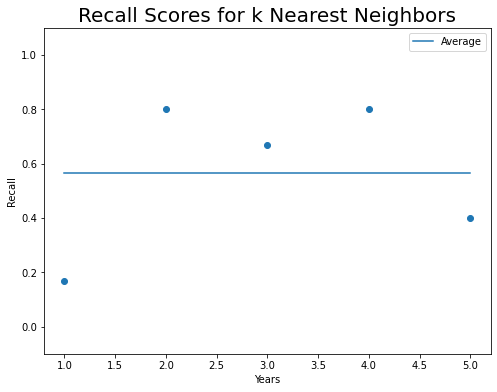

In [55]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_knn[1])

plt.plot(range(1,6), 5*[np.mean(metrics_knn[1])], label='Average')

plt.title('Recall Scores for k Nearest Neighbors', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

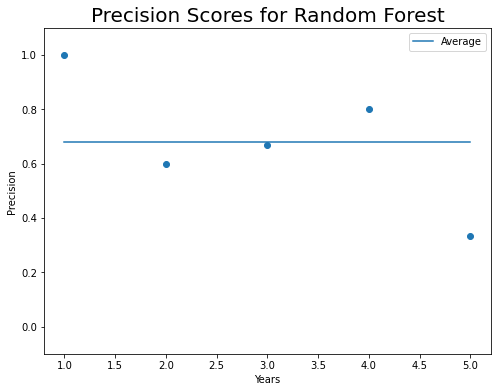

In [56]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_forest[0])

plt.plot(range(1,6), 5*[np.mean(metrics_forest[0])], label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [53]:
print('Recall:')
print(np.mean(metrics_knn[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics_knn[0], axis=1)[0])

Recall:
0.5666666666666667
Precision:
0.506031746031746


#### <font color='MediumOrchid'> For kNN, the precision increased but the recall decreased when adding features. Precision is decreasing over time.
</font>

### Logistic Regression

In [61]:
def est_log_reg(j):
    '''goes through C in range(j) on logistic regression models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            logreg = LogisticRegression(C=2**(-1*5), max_iter=1000)
            logreg.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=logreg.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [62]:
metrics_logreg=est_log_reg(1)

In [63]:
metrics_logreg

(array([[1.        , 0.75      , 0.75      , 0.55555556, 1.        ]]),
 array([[0.5, 0.6, 1. , 1. , 0.4]]))

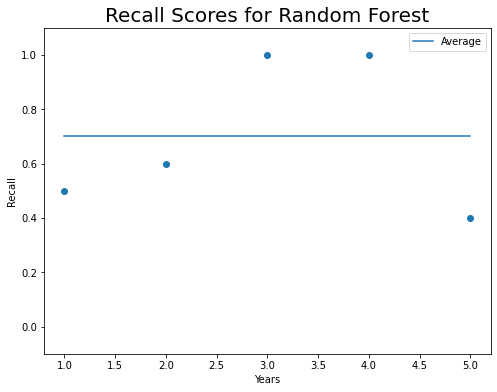

In [65]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_logreg[1])

plt.plot(range(1,6), 5*[np.mean(metrics_logreg[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

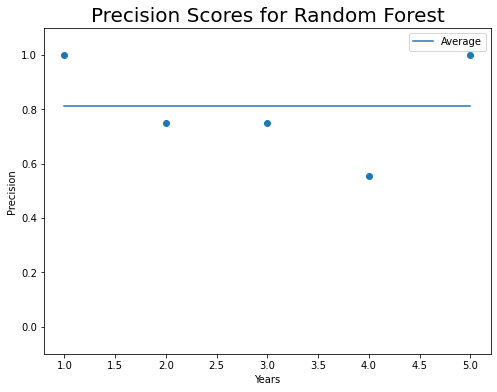

In [66]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_logreg[0])

plt.plot(range(1,6), 5*[np.mean(metrics_logreg[0])], label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [75]:
print('Recall:')
print(np.mean(metrics_logreg[1]))
print('Precision:')
print(np.mean(metrics_logreg[0]))

Recall:
0.7
Precision:
0.8111111111111111


#### <font color='MediumOrchid'> For Logistic Regression, recall went down but precision went up by a lot when adding features </font>

### Support Vector Machines

In [210]:
def est_poly_svc(j):
    '''goes through C in range(j) on SVC models on training set.
    with polynomial degree n
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=100000)
            svc.fit(
                train_set.iloc[train_index][viable_columns[:-1]],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][viable_columns[:-1]]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [211]:
metrics_poly2=est_poly_svc(1)

In [212]:
metrics_poly2

(array([[1.        , 0.75      , 0.66666667, 0.83333333, 1.        ]]),
 array([[0.66666667, 0.6       , 0.66666667, 1.        , 0.4       ]]))

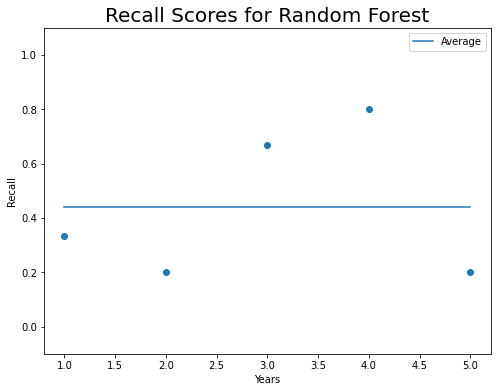

In [73]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_poly[1])

plt.plot(range(1,6), 5*[np.mean(metrics_poly[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

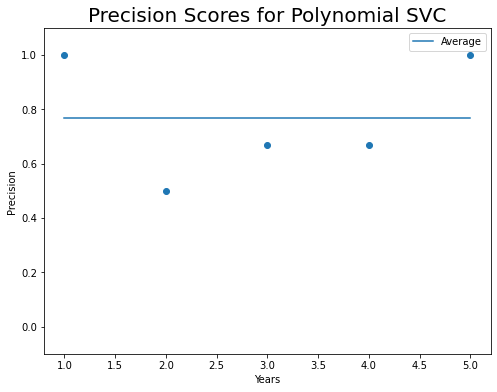

In [74]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_poly[0])

plt.plot(range(1,6), 5*[np.mean(metrics_poly[0])], label='Average')

plt.title('Precision Scores for Polynomial SVC', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [77]:
print('Recall:')
print(np.mean(metrics_poly[1], axis=1))
print('Precision:')
print(np.mean(metrics_poly[0], axis=1))

Recall:
[0.44]
Precision:
[0.76666667]


In [213]:
print('Recall:')
print(np.mean(metrics_poly2[1], axis=1))
print('Precision:')
print(np.mean(metrics_poly2[0], axis=1))

Recall:
[0.66666667]
Precision:
[0.85]


#### <font color=MediumOrchid> For SVC, both precision and recall went down when adding features. </font>

# A Voting Model based on the above

In [214]:
def voting(n):
    '''n = weights of the voting model
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((n,5))
    recs = np.zeros((n,5))
    for i in range(0,n):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make voting model 
            voting = VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=100000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=None)
            voting.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [215]:
metrics_voting=voting(1)

In [216]:
metrics_voting

(array([[1.        , 0.75      , 0.66666667, 0.66666667, 1.        ]]),
 array([[0.33333333, 0.6       , 0.66666667, 0.8       , 0.2       ]]))

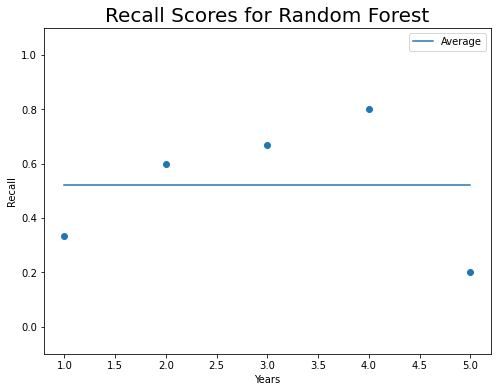

In [217]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_voting[1])

plt.plot(range(1,6), 5*[np.mean(metrics_voting[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [218]:
print('Recall:')
print(np.mean(metrics_voting[1]))
print('Precision:')
print(np.mean(metrics_voting[0]))

Recall:
0.5200000000000001
Precision:
0.8166666666666667


#### <font color=MediumOrchid> Precision went up but recall went down </font>

# Trends over validation sets

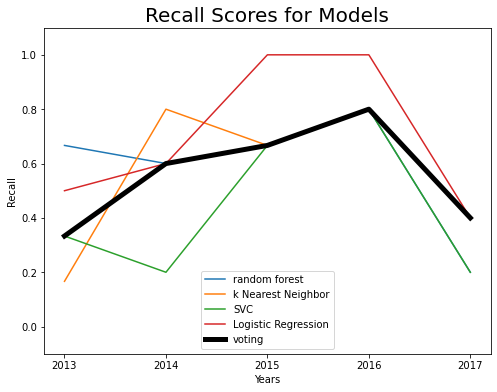

In [94]:
plt.figure(figsize=(8,6))



plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_forest[1]).reshape(-1,1), label='random forest')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_knn[1]).reshape(-1,1), label='k Nearest Neighbor')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_poly[1]).reshape(-1,1), label='SVC')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_logreg[1]).reshape(-1,1), label='Logistic Regression')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[1]).reshape(-1,1), linewidth=5, 
         label='voting',color='k')

plt.title('Recall Scores for Models', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

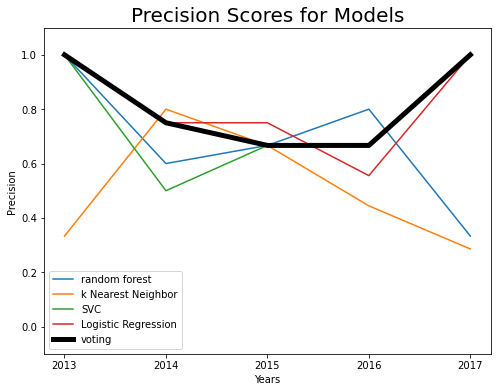

In [93]:
plt.figure(figsize=(8,6))


plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_forest[0]).reshape(-1,1), label='random forest')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_knn[0]).reshape(-1,1), label='k Nearest Neighbor')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_poly[0]).reshape(-1,1), label='SVC')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_logreg[0]).reshape(-1,1), label='Logistic Regression')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[0]).reshape(-1,1),linewidth=5, 
         label='voting', color='k')

plt.title('Precision Scores for Models', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

# Leaving off features

First, let's build a function that takes in a list of features, and spits out a table of precision/recall for all the different models

In [221]:
def feature_test(df, features):
    '''takes in a movie dataframe (df) and a list of features (features)
    outputs an array whose columns are model/precision/recall
    and whose rows are years + average'''
    answer=np.zeros((6,10))
    x=0
    for train_index, val_index in timeseries_split(df,5):
        forest=RandomForestClassifier(n_estimators=80, max_depth=10)
        forest.fit(df.iloc[train_index][features], df.iloc[train_index]['is_nominee'])
        pred1=forest.predict(df.iloc[val_index][features])
        #answer[x][0]=1
        answer[x][0]=precision_score(df.iloc[val_index]['is_nominee'], pred1, zero_division=0)
        answer[x][1]=recall_score(df.iloc[val_index]['is_nominee'], pred1, zero_division=0)
        
        knn=KNeighborsClassifier(n_neighbors=1, p=1)
        knn.fit(df.iloc[train_index][features], df.iloc[train_index]['is_nominee'])
        pred2=knn.predict(df.iloc[val_index][features])
        #answer[x][3]=2
        answer[x][2]=precision_score(df.iloc[val_index]['is_nominee'], pred2, zero_division=0)
        answer[x][3]=recall_score(df.iloc[val_index]['is_nominee'], pred2, zero_division=0)
        
        lreg=LogisticRegression(C=1/(2**5), max_iter=1000)
        lreg.fit(df.iloc[train_index][features], df.iloc[train_index]['is_nominee'])
        pred3=lreg.predict(df.iloc[val_index][features])
        #answer[x][6]=1
        answer[x][4]=precision_score(df.iloc[val_index]['is_nominee'], pred3, zero_division=0)
        answer[x][5]=recall_score(df.iloc[val_index]['is_nominee'], pred3, zero_division=0)
        
        svc=SVC(kernel='poly', degree=10, C=1/(2**9), max_iter=100000)
        svc.fit(df.iloc[train_index][features], df.iloc[train_index]['is_nominee'])
        pred4=svc.predict(df.iloc[val_index][features])
        #answer[x][0]=1
        answer[x][6]=precision_score(df.iloc[val_index]['is_nominee'], pred4, zero_division=0)
        answer[x][7]=recall_score(df.iloc[val_index]['is_nominee'], pred4, zero_division=0)
        
        voting=VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=100000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=None)
        voting.fit(df.iloc[train_index][features], df.iloc[train_index]['is_nominee'])
        pred5=voting.predict(df.iloc[val_index][features])
        #answer[x][0]=1
        answer[x][8]=precision_score(df.iloc[val_index]['is_nominee'], pred5, zero_division=0)
        answer[x][9]=recall_score(df.iloc[val_index]['is_nominee'], pred5, zero_division=0)
        
        x=x+1
    for j in range(10):
        answer[5][j] = np.mean([answer[i][j] for i in range(5)])
    return(answer)

In [220]:
test=feature_test(train_set,viable_columns)

In [149]:
test[5]

array([0.79333333, 0.66      , 0.50603175, 0.56666667, 0.81111111,
       0.7       , 0.76666667, 0.44      , 0.81666667, 0.56      ])

In [163]:
new_cols=viable_columns.copy()

In [164]:
new_cols.remove('United States')

new_cols

['Family',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Other',
 'G',
 'PG',
 'PG-13',
 'R',
 'Unrated',
 'metascore_available',
 'prev_dir',
 'prev_prod',
 'metascore_0',
 'metascore_ave',
 'month',
 'prev_pc',
 'runtime_ints']

In [167]:
all_metrics=[]
for feature in viable_columns:
    print(feature)
    new_cols=viable_columns.copy()
    new_cols.remove(feature)
    metrics=feature_test(train_set, new_cols)
    all_metrics.append(metrics[5])
    
all_metrics

United States
Family
Adventure
Comedy
Fantasy
Other
G
PG
PG-13
R
Unrated
metascore_available
prev_dir
prev_prod
metascore_0
metascore_ave
month
prev_pc
runtime_ints


C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[array([0.75      , 0.73333333, 0.50603175, 0.56666667, 0.74444444,
        0.66666667, 0.76666667, 0.44      , 0.73095238, 0.52666667]),
 array([0.68666667, 0.59333333, 0.50714286, 0.52666667, 0.8       ,
        0.66      , 0.76666667, 0.44      , 0.79761905, 0.56      ]),
 array([0.73      , 0.66      , 0.51714286, 0.56666667, 0.81111111,
        0.7       , 0.76666667, 0.44      , 0.81666667, 0.56      ]),
 array([0.70333333, 0.69333333, 0.51269841, 0.60666667, 0.74444444,
        0.7       , 0.76666667, 0.44      , 0.73095238, 0.56      ]),
 array([0.71333333, 0.59333333, 0.51714286, 0.56666667, 0.81111111,
        0.7       , 0.76666667, 0.44      , 0.81666667, 0.56      ]),
 array([0.71428571, 0.66      , 0.50603175, 0.56666667, 0.81111111,
        0.7       , 0.76666667, 0.44      , 0.79761905, 0.56      ]),
 array([0.72      , 0.59333333, 0.51714286, 0.56666667, 0.81111111,
        0.7       , 0.76666667, 0.44      , 0.81666667, 0.56      ]),
 array([0.71      , 0.66      , 0.

Now that we have our data, let's see if removing any single feature actually helped.

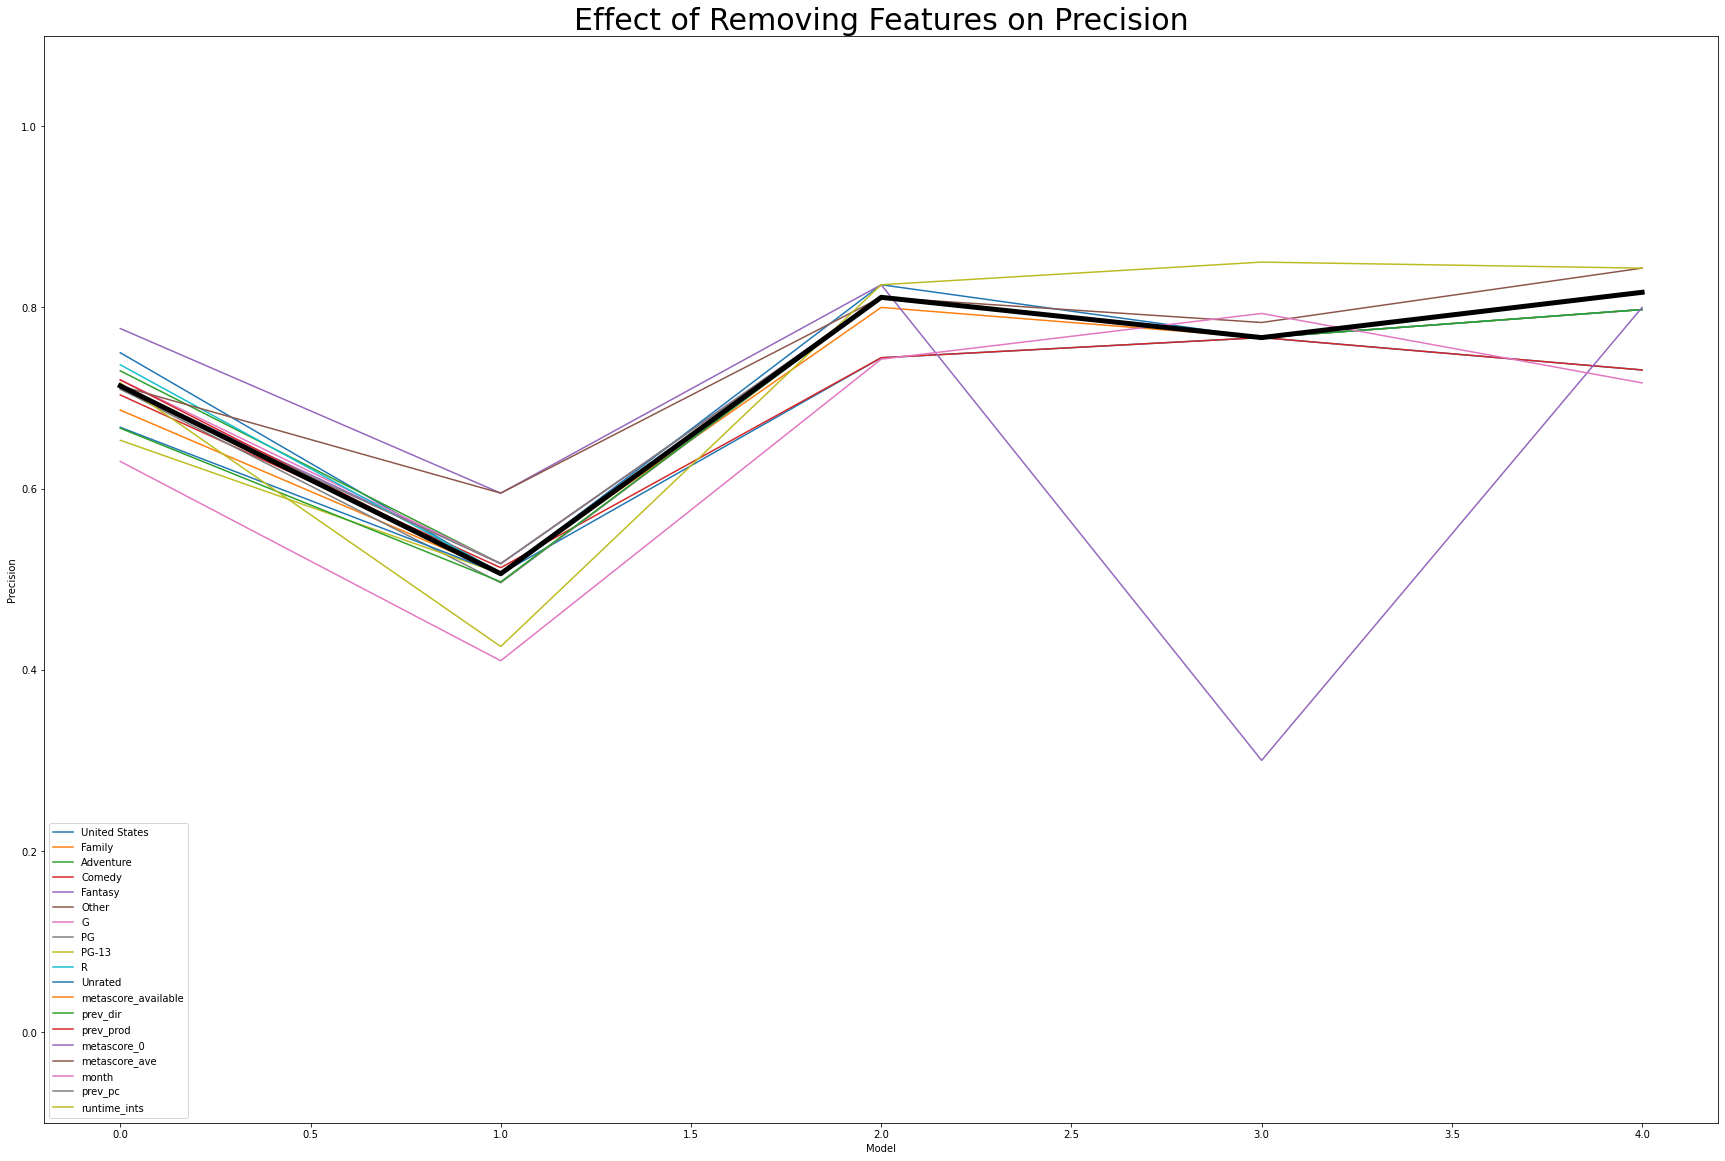

In [310]:
#Comparing Precisions
plt.figure(figsize=(30,20))

for i in range(len(all_metrics)):
    plt.plot(range(5), all_metrics[i][[0,2,4,6,8]], label=viable_columns[i])


plt.legend()
plt.plot(range(5), test[5][[0,2,4,6,8]], linewidth=5, color='k')

plt.ylim(-0.1, 1.1)
plt.ylabel('Precision')
plt.xlabel('Model')
plt.title('Effect of Removing Features on Precision', fontsize=30)

plt.show()

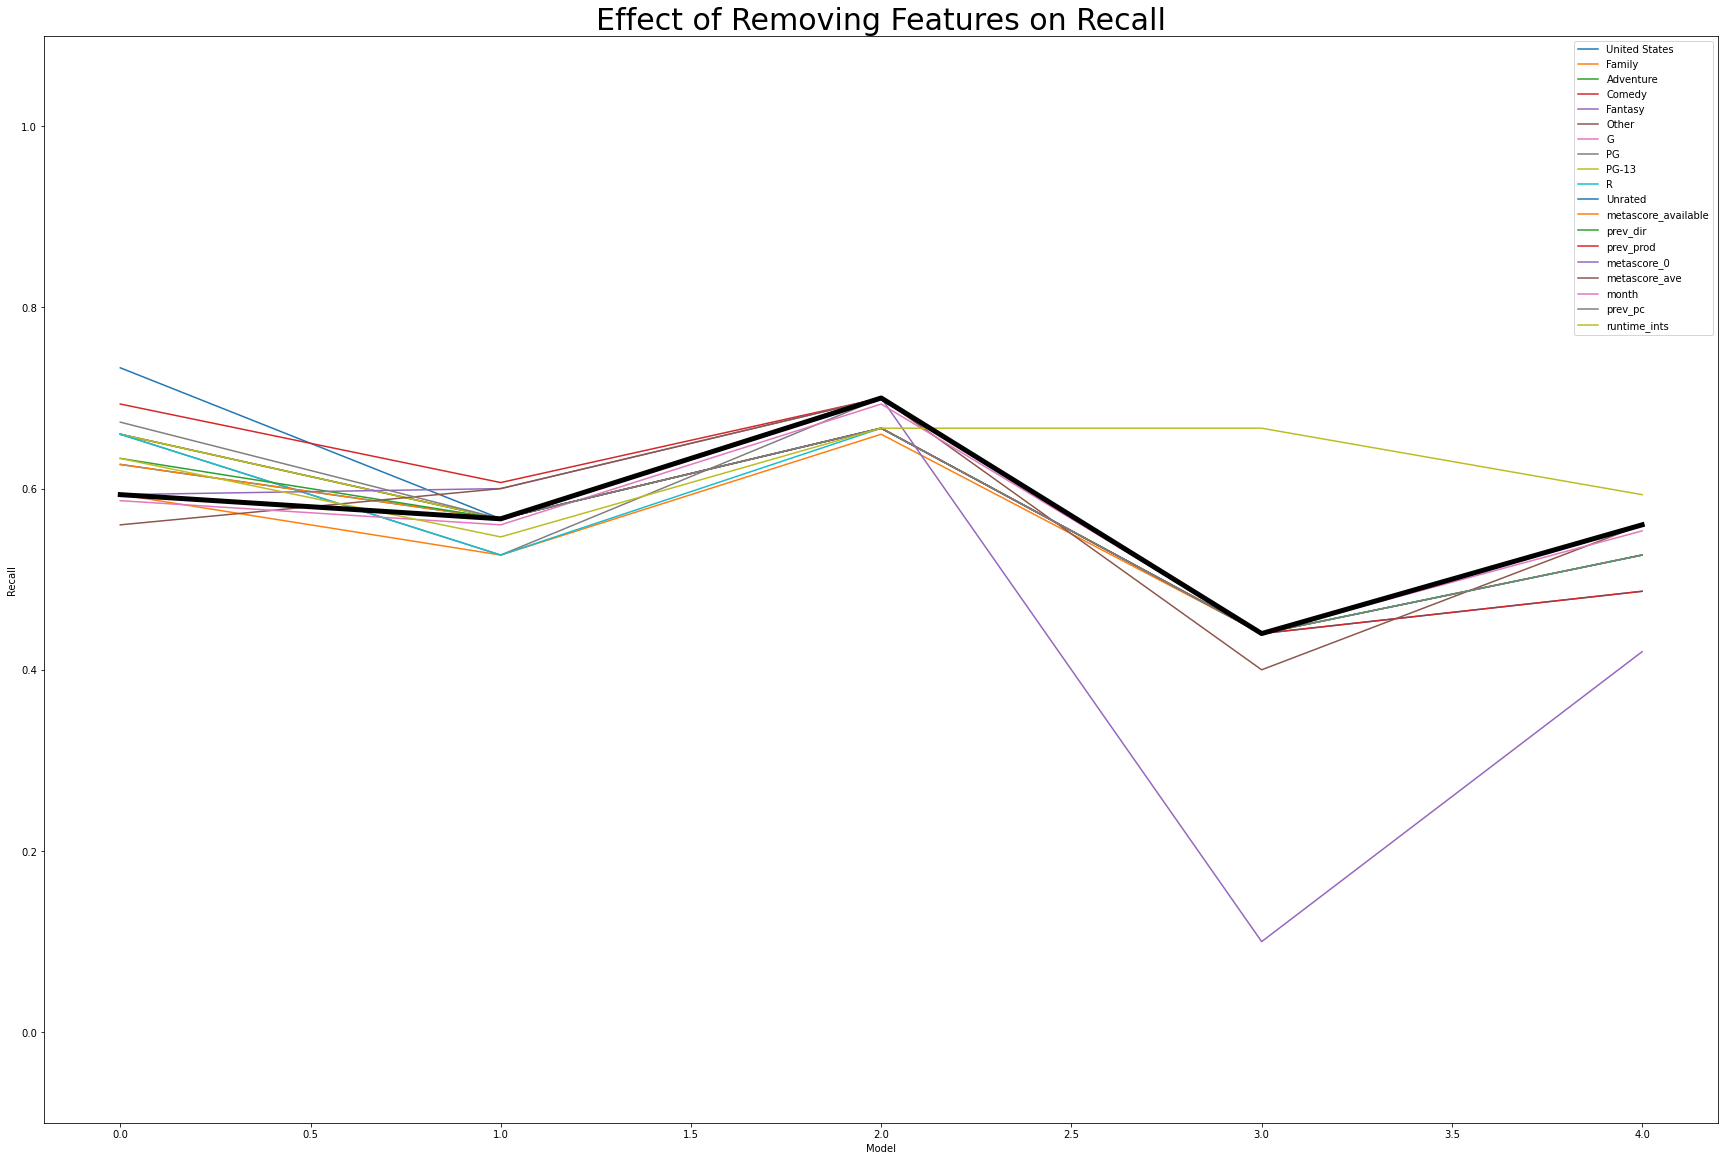

In [309]:
#Comparing Recalls
plt.figure(figsize=(30,20))

for i in range(len(all_metrics)):
    plt.plot(range(5), all_metrics[i][[1,3,5,7,9]], label=viable_columns[i])


plt.legend()
plt.plot(range(5), test[5][[1,3,5,7,9]], linewidth=5, color='k')

plt.ylim(-0.1, 1.1)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.title('Effect of Removing Features on Recall', fontsize=30)

plt.show()

So adding the metascore_0 column was extremely important to the SVC Model.  Removing runtime will be helpful for recall, but evens out for precision.

In [205]:
more_viable_columns = viable_columns[:-1]

more_viable_columns

['United States',
 'Family',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Other',
 'G',
 'PG',
 'PG-13',
 'R',
 'Unrated',
 'metascore_available',
 'prev_dir',
 'prev_prod',
 'metascore_0',
 'metascore_ave',
 'month',
 'prev_pc']

In [222]:
noruntime_metrics=feature_test(train_set, more_viable_columns)

noruntime_metrics

array([[1.        , 0.66666667, 0.5       , 0.33333333, 1.        ,
        0.33333333, 1.        , 0.66666667, 1.        , 0.5       ],
       [0.6       , 0.6       , 0.5       , 0.4       , 0.75      ,
        0.6       , 0.75      , 0.6       , 0.75      , 0.6       ],
       [0.66666667, 0.66666667, 0.42857143, 1.        , 0.75      ,
        1.        , 0.66666667, 0.66666667, 0.66666667, 0.66666667],
       [0.66666667, 0.8       , 0.5       , 0.8       , 0.625     ,
        1.        , 0.83333333, 1.        , 0.66666667, 0.8       ],
       [0.4       , 0.4       , 0.2       , 0.2       , 1.        ,
        0.4       , 1.        , 0.4       , 1.        , 0.4       ],
       [0.66666667, 0.62666667, 0.42571429, 0.54666667, 0.825     ,
        0.66666667, 0.85      , 0.66666667, 0.81666667, 0.59333333]])

# A different train-test split

In [232]:
def timeseries_split2(df, k, n):
    '''takes in a movie dataframe (df),  k (int)
    and outputs a tuple that behaves like kfold.split when kfold =kfold = TimeSeriesSplit(n_splits = k,
                           test_size = 1)
    but only keeps n years in each train_set
    that is, the output is a tuple of 2-tuples, where
    the first element of each tuple is the indices of the train set and
    the second element is the indices of the test set
    unlike TimeSeriesSplit it can only handle one dataframe at a time'''
    if len(df['year'].value_counts()) <k+n:
        raise ValueError("Not enough data for given k and n")
        
    df=df.copy()
    
    answer=[]
    i=0
    while i <k:
        last_year=df['year'].max()
        
        #get array of indices of last year in list
        index_set=np.array(df[df['year']==last_year].index)
        
        #delete rows from dataframe
        df=drop_test(df,[last_year])
        
        m=1
        temp_train=[]
        while m<n+1:
            temp_train=list(df[df['year'] == last_year-m].index) + temp_train
            m=m+1
        
        #add to train_sets
        index_set2=np.array(temp_train)
        
        new_set=(index_set2, index_set)
        answer=[new_set] + answer
        
        i=i+1
    
    return tuple(answer)

In [233]:
for train_index, test_index in timeseries_split2(main_df,5,10):
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    print()
    print()

TRAIN INDEX: [ 476  477  478 ... 2387 2388 2389]
TEST INDEX: [2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403
 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413 2414 2415 2416 2417
 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427 2428 2429 2430 2431
 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445
 2446 2447 2448 2449 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459
 2460 2461 2462 2463 2464 2465 2466 2467 2468 2469 2470 2471 2472 2473
 2474 2475 2476 2477 2478 2479 2480 2481 2482 2483 2484 2485 2486 2487
 2488 2489 2490 2491 2492 2493 2494 2495 2496 2497 2498 2499 2500 2501
 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515
 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527 2528 2529
 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541 2542 2543
 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557
 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571
 2572 2573 2574 

In [234]:
def trainset_test(df, y):
    '''takes in a movie dataframe (df) and limit of years (y)
    uses timeseries split 2 with value (df, 5, y)
    outputs an array whose columns are model/precision/recall
    and whose rows are years + average'''
    answer=np.zeros((6,10))
    x=0
    for train_index, val_index in timeseries_split2(df,5,y):
        forest=RandomForestClassifier(n_estimators=80, max_depth=10)
        forest.fit(df.iloc[train_index][more_viable_columns], df.iloc[train_index]['is_nominee'])
        pred1=forest.predict(df.iloc[val_index][more_viable_columns])
        #answer[x][0]=1
        answer[x][0]=precision_score(df.iloc[val_index]['is_nominee'], pred1, zero_division=0)
        answer[x][1]=recall_score(df.iloc[val_index]['is_nominee'], pred1, zero_division=0)
        
        knn=KNeighborsClassifier(n_neighbors=1, p=1)
        knn.fit(df.iloc[train_index][more_viable_columns], df.iloc[train_index]['is_nominee'])
        pred2=knn.predict(df.iloc[val_index][more_viable_columns])
        #answer[x][3]=2
        answer[x][2]=precision_score(df.iloc[val_index]['is_nominee'], pred2, zero_division=0)
        answer[x][3]=recall_score(df.iloc[val_index]['is_nominee'], pred2, zero_division=0)
        
        lreg=LogisticRegression(C=1/(2**5), max_iter=1000)
        lreg.fit(df.iloc[train_index][more_viable_columns], df.iloc[train_index]['is_nominee'])
        pred3=lreg.predict(df.iloc[val_index][more_viable_columns])
        #answer[x][6]=1
        answer[x][4]=precision_score(df.iloc[val_index]['is_nominee'], pred3, zero_division=0)
        answer[x][5]=recall_score(df.iloc[val_index]['is_nominee'], pred3, zero_division=0)
        
        svc=SVC(kernel='poly', degree=10, C=1/(2**9), max_iter=100000)
        svc.fit(df.iloc[train_index][more_viable_columns], df.iloc[train_index]['is_nominee'])
        pred4=svc.predict(df.iloc[val_index][more_viable_columns])
        #answer[x][0]=1
        answer[x][6]=precision_score(df.iloc[val_index]['is_nominee'], pred4, zero_division=0)
        answer[x][7]=recall_score(df.iloc[val_index]['is_nominee'], pred4, zero_division=0)
        
        voting=VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=100000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=None)
        voting.fit(df.iloc[train_index][more_viable_columns], df.iloc[train_index]['is_nominee'])
        pred5=voting.predict(df.iloc[val_index][more_viable_columns])
        #answer[x][0]=1
        answer[x][8]=precision_score(df.iloc[val_index]['is_nominee'], pred5, zero_division=0)
        answer[x][9]=recall_score(df.iloc[val_index]['is_nominee'], pred5, zero_division=0)
        
        x=x+1
    for j in range(10):
        answer[5][j] = np.mean([answer[i][j] for i in range(5)])
    return(answer)

In [239]:
test2=trainset_test(train_set,12)

In [256]:
test2

array([[1.        , 0.66666667, 0.5       , 0.33333333, 1.        ,
        0.33333333, 1.        , 0.66666667, 1.        , 0.33333333],
       [0.75      , 0.6       , 0.5       , 0.4       , 0.75      ,
        0.6       , 0.75      , 0.6       , 0.75      , 0.6       ],
       [0.75      , 1.        , 0.42857143, 1.        , 0.75      ,
        1.        , 0.66666667, 0.66666667, 0.75      , 1.        ],
       [0.71428571, 1.        , 0.5       , 0.8       , 0.625     ,
        1.        , 0.83333333, 1.        , 0.8       , 0.8       ],
       [0.5       , 0.4       , 0.2       , 0.2       , 1.        ,
        0.4       , 1.        , 0.4       , 1.        , 0.4       ],
       [0.74285714, 0.73333333, 0.42571429, 0.54666667, 0.825     ,
        0.66666667, 0.85      , 0.66666667, 0.86      , 0.62666667]])

In [238]:
all_metrics2=[]
for j in range(1,13):
    print(j)
    metrics=trainset_test(train_set,j)
    all_metrics2.append(metrics[5])
    
all_metrics2

1
2
3
4
5
6
7
8
9
10
11
12


[array([0.76      , 0.41333333, 0.46666667, 0.42      , 0.68333333,
        0.54666667, 0.73333333, 0.44      , 0.88333333, 0.40666667]),
 array([0.75      , 0.48666667, 0.48454545, 0.44666667, 0.55333333,
        0.54666667, 0.53      , 0.41333333, 0.75      , 0.40666667]),
 array([0.51333333, 0.49333333, 0.42454545, 0.41333333, 0.8       ,
        0.62666667, 0.78333333, 0.48666667, 0.58333333, 0.45333333]),
 array([0.64428571, 0.59333333, 0.45939394, 0.48666667, 0.77      ,
        0.62      , 0.80952381, 0.56      , 0.81666667, 0.55333333]),
 array([0.69666667, 0.63333333, 0.48857143, 0.55333333, 0.78428571,
        0.62666667, 0.75952381, 0.6       , 0.75      , 0.56      ]),
 array([0.71      , 0.59333333, 0.50222222, 0.58666667, 0.8       ,
        0.58666667, 0.74285714, 0.59333333, 0.72619048, 0.59333333]),
 array([0.67666667, 0.52      , 0.46793651, 0.58666667, 0.8       ,
        0.62666667, 0.75952381, 0.63333333, 0.73095238, 0.52666667]),
 array([0.65333333, 0.59333333, 0.

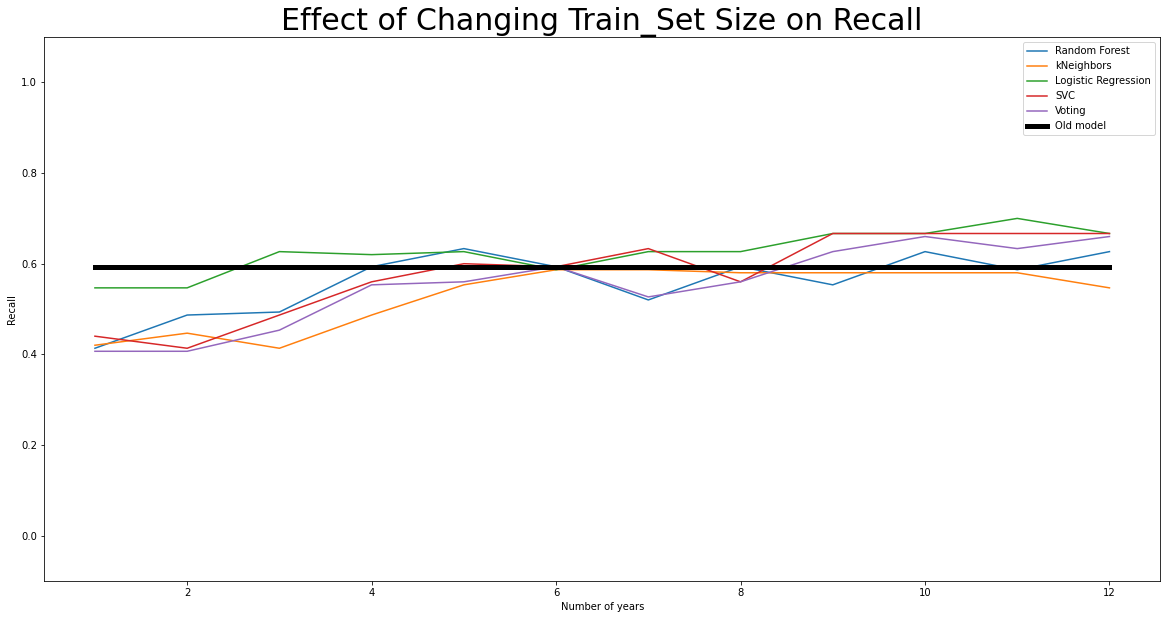

In [306]:
#Comparing Recalls
plt.figure(figsize=(20,10))


plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][1] for i in range(len(all_metrics2))], label='Random Forest')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][3] for i in range(len(all_metrics2))], label='kNeighbors')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][5] for i in range(len(all_metrics2))], label='Logistic Regression')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][7] for i in range(len(all_metrics2))], label='SVC')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][9] for i in range(len(all_metrics2))], label='Voting')


#plt.plot(range(5), test2[5][[1,3,5,7,9]], linewidth=5, color='k')
plt.plot([1,12], [0.59333333,0.59333333], linewidth=5, color='k', label='Old model')

plt.legend()
plt.ylim(-0.1, 1.1)
plt.ylabel('Recall')
plt.xlabel('Number of years')
plt.title('Effect of Changing Train_Set Size on Recall', fontsize=30)

plt.show()

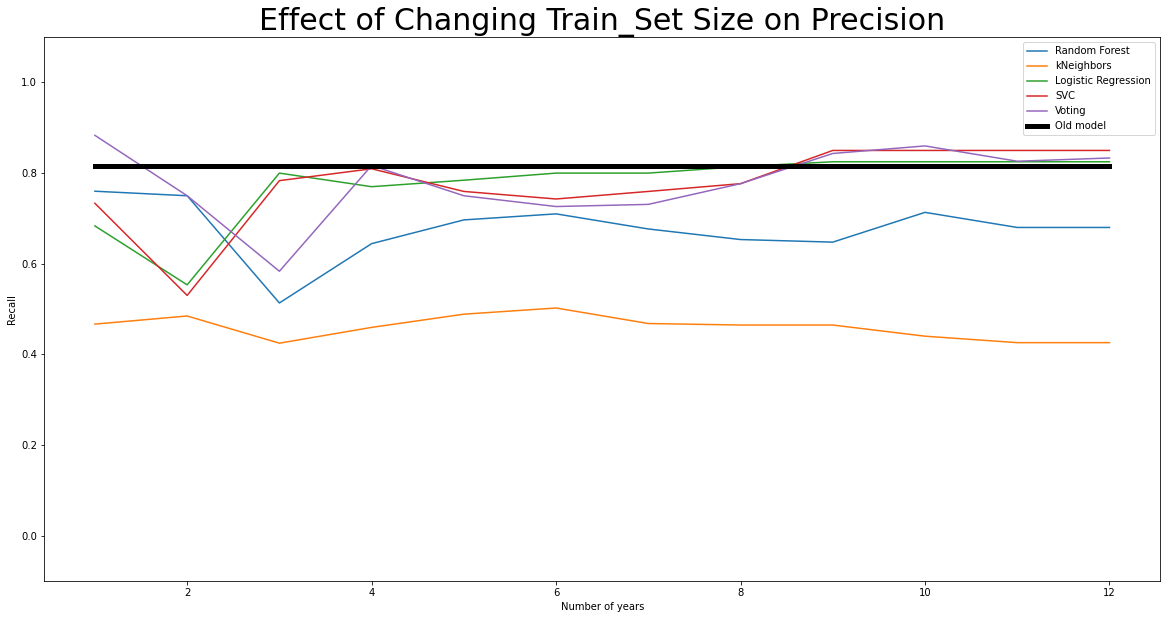

In [307]:
#Comparing Recalls
plt.figure(figsize=(20,10))


plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][0] for i in range(len(all_metrics2))], label='Random Forest')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][2] for i in range(len(all_metrics2))], label='kNeighbors')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][4] for i in range(len(all_metrics2))], label='Logistic Regression')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][6] for i in range(len(all_metrics2))], label='SVC')
plt.plot(range(1,len(all_metrics2)+1), [all_metrics2[i][8] for i in range(len(all_metrics2))], label='Voting')


plt.plot([1,12], [0.81666667,0.81666667], linewidth=5, color='k', label='Old model')

plt.legend()
plt.ylim(-0.1, 1.1)
plt.ylabel('Recall')
plt.xlabel('Number of years')
plt.title('Effect of Changing Train_Set Size on Precision', fontsize=30)

plt.show()

So, it's actually better to use a fixed number of years (12) in your training sets!

# Ensemble types

In [283]:
def voting2(weights_L):
    '''n = weights of the voting model
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((1,5))
    recs = np.zeros((1,5))
    for i in range(0,1):
        x=0
        for train_index, val_index in timeseries_split2(train_set,5,12):

            # make voting model 
            voting = VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=100000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=weights_L)
            voting.fit(
                train_set.iloc[train_index][more_viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(train_set.iloc[val_index][more_viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [284]:
w_1111=voting2([1,1,1,1])

In [285]:
w_1111

(array([[1.        , 0.75      , 0.66666667, 0.8       , 1.        ]]),
 array([[0.5       , 0.6       , 0.66666667, 0.8       , 0.2       ]]))

In [286]:
w_1122=voting2([1,1,2,2])

In [287]:
w_1122

(array([[1.        , 0.75      , 0.75      , 0.83333333, 1.        ]]),
 array([[0.33333333, 0.6       , 1.        , 1.        , 0.4       ]]))

In [304]:
np.average(w_1122[0])

0.8666666666666668

In [305]:
np.average(w_1122[1])

0.6666666666666667

In [288]:
w_1234=voting2([1,2,3,4])
w_1234

(array([[1.   , 0.75 , 0.75 , 0.625, 1.   ]]),
 array([[0.5, 0.6, 1. , 1. , 0.4]]))

In [289]:
w_1243=voting2([1,2,4,3])

In [290]:
w_1243

(array([[1.        , 0.75      , 0.75      , 0.71428571, 1.        ]]),
 array([[0.5, 0.6, 1. , 1. , 0.4]]))

In [291]:
w_1143=voting2([1,1,4,3])
w_1143

(array([[1.        , 0.75      , 0.66666667, 0.83333333, 1.        ]]),
 array([[0.66666667, 0.6       , 0.66666667, 1.        , 0.4       ]]))

Honestly it seems like weights [1,1,2,2] does best